In [ ]:
''' this code is adapted from
https://medium.com/ersiliaio/downloading-pubchem-bioassays-made-easy-132ddd8e21c4
& https://projects.volkamerlab.org/teachopencadd/talktorials/T013_query_pubchem.html
'''

In [ ]:
## libraries
import json
import requests
import os
import pandas as pd
from collections import OrderedDict

In [ ]:
## this first part defines functions to download json file
## from pubchem bioassay database

PUBCHEM_PREFIX = "PUBCHEM"

class PubChemBioAssayRecord(object):
    def __init__(self, assay_id, batch_size=10000):
        self.batch_size = batch_size
        self.url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/assay/aid/{}".format(
            assay_id
        )
        r = requests.get("{0}/sids/json".format(self.url))
        self.record = json.loads(r.text)

    def _chunker(self, seq, size):
        return (seq[pos : pos + size] for pos in range(0, len(seq), size))

    def _get_id(self, record):
        return record["InformationList"]["Information"][0]["AID"]

    def _get_sids(self, record):
        sids = record["InformationList"]["Information"][0]["SID"]
        sids.sort()
        return sids

    def _get_description(self, record):
        req = requests.get("{}/description/json".format(self.url))
        record = json.loads(req.text)
        return record["PC_AssayContainer"][0]["assay"]["descr"]

    def _get_data(self, record):
        data = []
        for chunk in self._chunker(self._get_sids(record), self.batch_size):
            s = ",".join([str(sid) for sid in chunk])
            r = requests.post("{0}/json".format(self.url), data={"sid": s})
            result = json.loads(r.text)["PC_AssaySubmit"]["data"]
            data.append(result)
        data = [d for chunk in data for d in chunk]
        return data

    def _get_cids_from_sids(self, sids):
        sid2cids = {}
        for chunk in self._chunker(sids, self.batch_size):
            s = ",".join([str(sid) for sid in chunk])
            url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/sid/cids/json"
            r = requests.post(url, data={"sid": s})
            result = json.loads(r.text)
            if "InformationList" not in result:
                return {}
            result = result["InformationList"]["Information"]
            for res in result:
                if "CID" not in res:
                    continue
                sid2cids[res["SID"]] = res["CID"]
        return sid2cids

    def _get_smiles_from_cids(self, cids):
        cid2smiles = {}
        for chunk in self._chunker(cids, self.batch_size):
            s = ",".join([str(cid) for cid in list(set(cids))])
            url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/property/CanonicalSmiles,IsomericSmiles/JSON".format(
                s
            )
            r = requests.post(url, data={"cid": s})
            result = json.loads(r.text)["PropertyTable"]["Properties"]
            for res in result:
                if "CanonicalSMILES" in res:
                    cid2smiles[res["CID"]] = res["CanonicalSMILES"]
                elif "IsomericSMILES" in res:
                    cid2smiles[res["CID"]] = res["IsomericSMILES"]
                else:
                    continue
        return cid2smiles

    def _get_substances(self, sids):
        sid2cids = self._get_cids_from_sids(sids)
        all_cids = list(set([c for cid in list(sid2cids.values()) for c in cid]))
        if not all_cids:
            return [(sid, None, None) for sid in sids]
        cid2smiles = self._get_smiles_from_cids(all_cids)
        compounds = {}
        for sid in sids:
            if sid not in sid2cids:
                compounds[sid] = [None, None]
            else:
                for cid in sid2cids[sid]:
                    found = False
                    if not found and cid in cid2smiles:
                        compounds[sid] = [cid, cid2smiles[cid]]
                        found = True
                if not found:
                    compounds[sid] = [None, None]
        return compounds

    def _get_data_with_compounds(self, record):
        sids = self._get_sids(record)
        compounds = self._get_substances(sids)
        data = self._get_data(record)
        for i in range(len(data)):
            sid = data[i]["sid"]
            data[i]["cid"] = compounds[sid][0]
            data[i]["smiles"] = compounds[sid][1]
        return data

    def get(self):
        result = {
            "assay_id": self._get_id(self.record),
            "description": self._get_description(self.record),
            "data": self._get_data_with_compounds(self.record),
        }
        return {
            "AssayId": "{0}{1}".format(PUBCHEM_PREFIX, result["assay_id"]),
            "Description": result["description"],
            "Data": result["data"],
        }

    def save_json(self, path):
        data = self.get()
        assay_id = data["AssayId"]
        with open(os.path.join(path, "{}.json".format(assay_id)), "w") as outfile:
            json.dump(data, outfile)

In [ ]:
## this second part defines functions to convert json file
## from pubchem bioassay database into pandas df

class PubChemBioAssayJsonConverter(object):
    def __init__(self, path, json_file):
        self.name = json_file.split(".")[0]
        with open(os.path.join(path, json_file), "r") as f:
            self.record = json.load(f)

    def _get_assay_id(self, record):
        assay_id = record["AssayId"]
        return assay_id

    def _get_description(self, record):
        description = record["Description"]
        return description

    def _get_data(self, record):
        data = record["Data"]
        return data

    def _get_tid_names(self):
        tid2name = {}
        results = self._get_description(self.record)["results"]
        for i in range(len(results)):
            tid = results[i]["tid"]
            name = results[i]["name"]
            tid2name[tid] = name
        return tid2name

    def _get_sid_cid_smiles(self):
        data = self._get_data(self.record)
        substances = {}
        for i in range(len(data)):
            substances[i] = [data[i]["sid"], data[i]["cid"], data[i]["smiles"]]
        return substances

    def _get_tid_results(self):
        data = self._get_data(self.record)
        sid2value = {}
        for i in range(len(data)):
            results = data[i]["data"]
            tid2value = OrderedDict()
            for i2 in range(len(results)):
                value = results[i2]["value"]
                for k, v in value.items():
                    val = v
                tid2value[results[i2]["tid"]] = val
            sid2value[i] = tid2value

        tid2name = self._get_tid_names()
        tid_int = [k for k in tid2name.keys()]

        for t in tid_int:
            for k, v in sid2value.items():
                tid_res = []
                for k2, v2 in v.items():
                    tid_res += [k2]
                if t not in tid_res:
                    v[t] = None

        for k, v in sid2value.items():
            for key in tid_int:
                v[key] = v.pop(key)

        return sid2value

    def _get_outcome(self):
        data = self._get_data(self.record)
        sid2outcome = {}
        for i in range(len(data)):
            sid2outcome[i] = data[i]["outcome"]
        return sid2outcome

    def _substances_to_df(self):
        substances = self._get_sid_cid_smiles()

        df = pd.DataFrame.from_dict(
            data=substances, orient="index", columns=["sid", "cid", "smiles"]
        )
        return df

    def _outcome_to_df(self):
        outcome = self._get_outcome()
        df = pd.DataFrame.from_dict(data=outcome, orient="index", columns=["outcome"])
        return df

    def _tid_to_df(self):
        sid2value = self._get_tid_results()
        tid2name = self._get_tid_names()
        tid_names = [k for k in tid2name.values()]
        df = pd.DataFrame.from_dict(data=sid2value, orient="index")
        df.columns = tid_names
        return df

    def get_description(self, path):
        descr = self._get_description(self.record)
        with open(os.path.join(path, "{}_descr.txt".format(self.name)), "w") as f:
            for k, v in descr.items():
                f.write("%s:%s\n" % (k, v))

    def get_outcome(self):
        df1 = self._substances_to_df()
        df2 = self._outcome_to_df
        df = pd.concat([df1, df2], axis=1)
        return df

    def get_all_results(self):
        df1 = self._substances_to_df()
        df2 = self._outcome_to_df()
        df3 = self._tid_to_df()
        df = pd.concat([df1, df2, df3], axis=1)
        return df

    def save_df(self, df, path):
        df.to_csv(os.path.join(path, "{}.csv".format(self.name)), index=False)

In [ ]:
import math
import pandas as pd
import numpy as np

In [ ]:
AID=1805801
c = PubChemBioAssayRecord(str(AID))
c.save_json("./sample_data")
## saving csv
c = PubChemBioAssayJsonConverter("./sample_data", "PUBCHEM" +str(AID) + ".json")
df = c.get_all_results()
c.save_df(df, "./sample_data")
c.get_description("./sample_data")

## open in pandas
file=AID
df = pd.read_csv('./sample_data/PUBCHEM' + str(file) + '.csv')

#df

,Drug_ID,Drug,label,IC50,Target_ID,pIC50
0,cid_5280443.0,C1=CC(=CC=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O,inactive,280.80,Replicase polyprotein 1ab,1.270113
1,cid_5280445.0,C1=CC(=C(C=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O)O,inactive,20.00,Replicase polyprotein 1ab,3.912023
2,cid_5280343.0,C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O,inactive,23.80,Replicase polyprotein 1ab,3.738070
3,cid_4124851.0,CN1C(=O)N(C(=O)S1)CC2=CC=CC=C2,active,2.15,Replicase polyprotein 1ab,6.142287
4,cid_5564.0,C1=CC(=C(C=C1Cl)O)OC2=C(C=C(C=C2)Cl)Cl,inactive,75.00,Replicase polyprotein 1ab,2.590267
...,...,...,...,...,...,...
647,cid_2918713.0,CCOC1=CC=C(C=C1)N2C(=O)CC(C2=O)SC3=NC(=CC(=N3)C)C,inactive,300.00,Replicase polyprotein 1ab,1.203973
648,cid_162533914.0,COC1=CC=CC(=C1)C2=NC(=NC(=O)C2C#N)SCC(=O)NC3=C...,inactive,300.00,Replicase polyprotein 1ab,1.203973
649,cid_162533915.0,CCCCN(C)CC1C2CCCCC2CC(O1)CNC(CC3=CN=CN3)C=O,inactive,440.00,Replicase polyprotein 1ab,0.820981
650,cid_162533916.0,CCOC(=O)C=CC(CC1CCNC1=O)NC(=O)C(CC=C(C)C)CC(=O...,inactive,800.00,Replicase polyprotein 1ab,0.223144


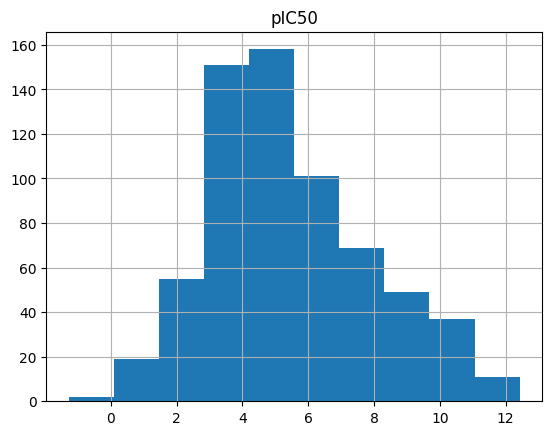

In [ ]:
## add prefix
df['cid'] = 'cid_' + df['cid'].astype(str)

## add labels
df['outcome'] = df['outcome'].replace([1], 'inactive')
df['outcome'] = df['outcome'].replace([2], 'active')
## remove null IC50 compounds
df = df[df['IC50'].notna()]
## make sure numbers are floats
df = df.astype({"IC50": "float64"}) ## get float numbers
## remove duplicates based on sid
df.drop_duplicates("sid", keep="first", inplace=True)
## reset index
df.reset_index(drop=True, inplace=True)
## drop unwanted columns
df = df.drop(['sid', 'Standard Relation', 'Ki', 'IC50', 'EC50 Qualifier', 'Standard Type', 'EC50', 'Target Accession(s)', 'Ligand'], axis=1)
## rename column
df.columns = ['Drug_ID', 'Drug', 'label', 'IC50', 'Target_ID']

## log IC50 values
## reset row indices
df.reset_index(drop=True, inplace=True)

import numpy as np
df['pIC50'] = np.log(df['IC50'] * 0.001) * (-1)
df.hist(column="pIC50")
## df = df.drop(['IC50'], axis=1)

df


In [ ]:
print("the number of compounds is " + str(df.shape[0]))
print(' ')
print("Class blance is ")
df['label'].value_counts()


the number of compounds is 652
 
Class blance is 


active      362
inactive    290
Name: label, dtype: int64

In [ ]:
## This script to balnce the dataset in pos-negative samples
## it is defined in radius the proportion of majority class
## however, it only would be useful if inactives are the majority class
## and posses more samples available than the radius defined

output_df = df
radius=2 ## radio 1:2
actives = output_df.loc[output_df["label"] == "active", :]
num_of_actives = len(actives)

negatives = output_df.loc[output_df["label"] == "inactive", :]
sample_of_negatives = negatives.sample(int(radius)*num_of_actives)

data = pd.concat([actives, sample_of_negatives], ignore_index=True)

print("the number of compounds is " + str(data.shape[0]))
print(' ')
print("Class blance is ")
data['label'].value_counts()